# Search algorithms AC5

## Imports

In [1]:
import heapq
import json
import networkx as nx
import matplotlib.pyplot as plt

## Data Loads

In [2]:
with open('2324_GIA04_CA5_Search_data_routes.json', encoding='utf-8') as f:
    data = json.load(f)

## Graphs functions

In [3]:
def build_graph(data):
    G = nx.DiGraph()

    for city in data['cities']:
        G.add_node(city['name'], pos=(city['latitude'], city['longitude']))
    for connection in data['connections']:
        G.add_edge(connection['from'], connection['to'], weight=connection['distance'], duration=connection['duration'])
        
    return G

In [4]:
def new_path(origin, start, finish):
    
    current = finish
    path = []

    while current != start:
        path.append(current)
        current = origin[current]
        
    path.append(start)
    path.reverse()

    return path

In [5]:
def visualise_path(graph, path):

    pos = nx.get_node_attributes(graph, 'pos')
    nx.draw(graph, pos, with_labels=True, node_size=300)
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.show()

## A* Algorithm
Find the shortest path from origin to destination

In [6]:
def cost_cal(next, finish, graph):
    
    pos = nx.get_node_attributes(graph, 'pos')
    return ((pos[next][0] - pos[finish][0])**2 + (pos[next][1] - pos[finish][1])**2)**0.5


In [7]:
def A(graph, start, finish):
    
    q = []
    heapq.heappush(q, (0, start))
    origin = {start: None}
    cost = {start: 0}

    while q:
        current = heapq.heappop(q)[1]

        if current == finish:
            break

        for next in graph.neighbors(current):
            new_cost = cost[current] + graph[current][next]['weight']

            if next not in cost or new_cost < cost[next]:
                cost[next] = new_cost
                priority = new_cost + cost_cal(next, finish, graph)
                heapq.heappush(q, (priority, next))
                origin[next] = current

    return new_path(origin, start, finish)
    

## CSP Algorithm
Find a path to go from origin to destination respecting a set of restrictions: 


In our case the restrictions are: 
1) Maximum Total Distance ( The sum of all edges' distances in the path should not exceed this value )
2) Maximum Duration per Stage ( No single segment of the journey should take more than this duration )

In [8]:
def good(graph, path, max_distance, max_duration):
    
    total_distance = 0

    for i in range(len(path) - 1):
        edge = graph.get_edge_data(path[i], path[i+1])
        if not edge:
            return False
        if max_duration and edge['duration'] > max_duration:
            return False
        total_distance += edge['weight']

    return max_distance is None or total_distance <= max_distance

In [9]:
def dfs(graph, current, finish, path, max_distance, max_duration):
    
    if current == finish:
        return path

    for next in graph.neighbors(current):
        if next not in path:
            result = dfs(graph, next, finish, path + [next], max_distance, max_duration)
            if result and good(graph, result, max_distance, max_duration):
                return result

    return None

In [10]:
def CSP(graph, start, finish, max_distance, max_duration):
    return dfs(graph, start, finish, [start], max_distance, max_duration)

## Test the algorithms

Path found by A* algorithm: ['Barcelona', 'Palamós']
Total distance: 117.897 km
Total duration: 52.81 minutes


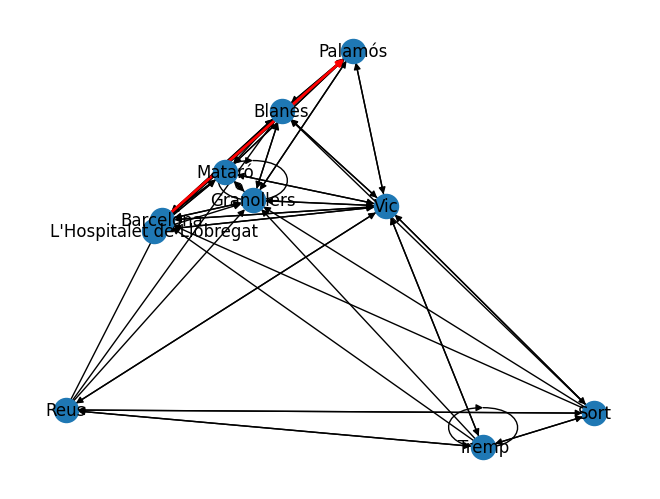

Path found by CSP algorithm: ['Barcelona', 'Granollers', 'Blanes', 'Palamós']
Total distance: 145.439 km
Total duration: 79.59 minutes


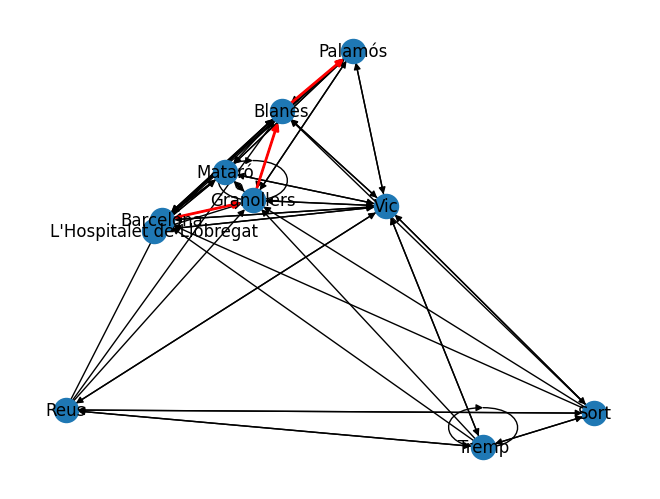

In [12]:
graph = build_graph(data)

start = 'Barcelona'
finish = 'Palamós'

# Check if the city exists
if start not in graph.nodes or finish not in graph.nodes:
    print("City not found in the dataset")
else:
    path_A = A(graph, start, finish)
    print(f"Path found by A* algorithm: {path_A}")
    #divite the total distance by 1000 to get the distance in km and the total duration by 100 to get the duration in minutes
    print(f"Total distance: {sum(graph[path_A[i]][path_A[i+1]]['weight'] for i in range(len(path_A) - 1)) / 1000} km")
    print(f"Total duration: {sum(graph[path_A[i]][path_A[i+1]]['duration'] for i in range(len(path_A) - 1)) / 100 } minutes")

    visualise_path(graph, path_A)

    # if one of the copnditions is wished to not be taken into account - set the value of it to None

    path_CSP = CSP(graph, start, finish, 150000, 3000) # ex: no more than 150 km and 50 minutes
    if path_CSP:
        print(f"Path found by CSP algorithm: {path_CSP}")
        print(f"Total distance: {sum(graph[path_CSP[i]][path_CSP[i+1]]['weight'] for i in range(len(path_CSP) - 1)) / 1000} km")
        print(f"Total duration: {sum(graph[path_CSP[i]][path_CSP[i+1]]['duration'] for i in range(len(path_CSP) - 1)) / 100 } minutes")
        visualise_path(graph, path_CSP)
    else:
        print("No path found by CSP algorithm that satisfies the constraints.")
